In [43]:
!pip install transformers datasets

In [44]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from transformers import pipeline
from datasets import load_dataset
from transformers import AutoTokenizer
from torchinfo import summary
from transformers import AutoModelForSequenceClassification, AutoConfig, \
  Trainer, TrainingArguments

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [45]:
df_ = pd.read_csv('/kaggle/input/bert-sentiment-airlinetweets/AirlineTweets.csv')
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [46]:
df = df_[['airline_sentiment', 'text']].copy()
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

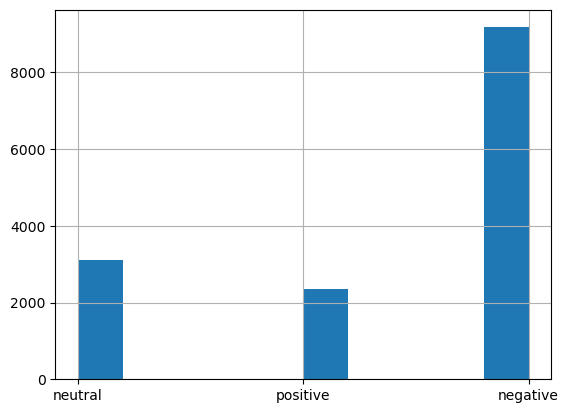

In [47]:
df['airline_sentiment'].hist()

In [48]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [49]:
df2 = df[['text', 'target']]
df2.columns = ['sentence', 'label']
df2.to_csv('data.csv', index=None)

In [50]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [51]:
raw_dataset = load_dataset('csv', data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-efccaf3a9539a05d/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [53]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [54]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [55]:
checkpoint = 'distilbert-base-cased'

In [56]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [57]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

def get_label(d):
  return target_map[d['label']]

def plot_cm(cm):
  classes = ['negative', 'positive', 'neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [58]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [59]:
config = AutoConfig.from_pretrained(checkpoint)

In [60]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.30.2",
  "vocab_size": 28996
}

In [61]:
config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [62]:
config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [63]:
config.id2label = {v:k for k, v in target_map.items()}
config.label2id = target_map

In [64]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, config=config)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.wei

In [65]:
!pip install torchinfo

In [66]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [67]:
model_beforefinetuning = pipeline('text-classification',
                      model=model,
                       tokenizer=tokenizer,
                      device=0)
s = split['test']['sentence'][777]
print(s)
model_beforefinetuning(s)

@united here we go again. 2 of 3 segments SFO--New York RT were delayed OVER 2 hrs each! Why do you suck so BAD!?!Maybe another line of bus?


[{'label': 'positive', 'score': 0.352590411901474}]

In [68]:
model_beforefinetuning("It made my day")

[{'label': 'positive', 'score': 0.36676880717277527}]

In [69]:
model_beforefinetuning("It ruined my day")

[{'label': 'positive', 'score': 0.3710106313228607}]

In [70]:
test_pred_beforefinetuning = model_beforefinetuning(split['test']['sentence'])

In [71]:
test_pred_beforefinetuning = [get_label(d) for d in test_pred_beforefinetuning]

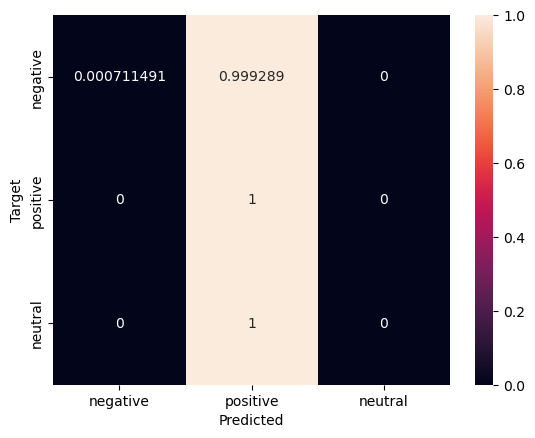

In [72]:
cm = confusion_matrix(split['test']['label'], test_pred_beforefinetuning, normalize='true')
plot_cm(cm)

In [73]:
training_args = TrainingArguments(
  output_dir='training_dir',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=3,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
)

In [74]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [75]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.552400,0.436913,0.825137,0.771542
2,0.349200,0.508291,0.829235,0.777746
3,0.239200,0.664884,0.835838,0.784131


TrainOutput(global_step=1923, training_loss=0.3309204609395313, metrics={'train_runtime': 124.5924, 'train_samples_per_second': 246.757, 'train_steps_per_second': 15.434, 'total_flos': 388376501242176.0, 'train_loss': 0.3309204609395313, 'epoch': 3.0})

In [76]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [77]:
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-1282',
                      device=0)

In [78]:
s = split['test']['sentence'][777]
print(s)
savedmodel(s)

@united here we go again. 2 of 3 segments SFO--New York RT were delayed OVER 2 hrs each! Why do you suck so BAD!?!Maybe another line of bus?


[{'label': 'negative', 'score': 0.997057318687439}]

In [79]:
savedmodel("It made my day")

[{'label': 'positive', 'score': 0.9393060803413391}]

In [80]:
savedmodel("It ruined my day")

[{'label': 'negative', 'score': 0.9926032423973083}]

In [81]:
test_pred_afterfinetuning = savedmodel(split['test']['sentence'])

In [82]:
test_pred_afterfinetuning = [get_label(d) for d in test_pred_afterfinetuning]

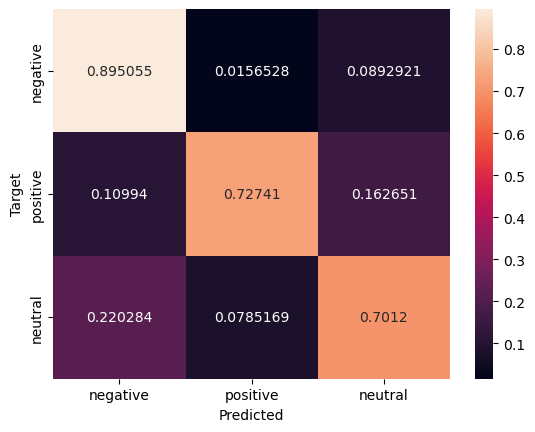

In [83]:
cm = confusion_matrix(split['test']['label'], test_pred_afterfinetuning, normalize='true')
plot_cm(cm)